In [ ]:
import os

# Set your repo URL and folder name
repo_url = "https://github.com/bpleahey/thesis.git"
repo_dir = "thesis"
branch = "main"  # <-- your branch name

# Check if already inside the repo
cwd = os.getcwd()
if os.path.basename(cwd) == repo_dir:
    print(f"[INFO] Already inside '{repo_dir}' folder. Skipping clone.")
else:
    # Clone if not already in it
    if not os.path.exists(repo_dir):
        # clone and checkout correct branch
        !git clone --branch {branch} {repo_url}
    else:
        print(f"[INFO] '{repo_dir}' already exists. Skipping clone.")

    # Move into the repo
    %cd {repo_dir}

    # Make sure we are on the correct branch
    !git checkout {branch}

# Install requirements
!pip install -r requirements.txt

In [ ]:
!git fetch

In [ ]:
import os
from IPython import get_ipython

# Get current working directory
cwd = os.getcwd()

# Check if we're inside 'thesis' folder. If not, move into it.
if os.path.basename(cwd) == 'thesis':
    print("[INFO] Inside 'thesis/' — moving up one level.")
    get_ipython().run_line_magic('cd', '..')
else:
    print(f"[INFO] Current directory is '{os.path.basename(cwd)}' — no need to move.")

In [ ]:
# Download train dataset
!pip install gdown
!gdown 'https://drive.google.com/uc?id=12CwITCDBB0LZBKJcCdkoSfY-Cr_FIOx_'

In [ ]:
!unzip train_val.zip -d train_val

In [ ]:
# basic preprocessing/cropping

import os
import cv2
import glob
import numpy as np
from tqdm import tqdm  # progress bar

dataset_path = 'train_val/'
image_files = glob.glob(os.path.join(dataset_path, '**', '*.jpg'), recursive=True)

CROP = 100  # pixels to crop from each side

for image_file in tqdm(image_files, desc="Processing images"):
    image = cv2.imread(image_file)

    if image is None:
        print(f"Error loading image: {image_file}")
        continue

    height, width = image.shape[:2]
    label_file = os.path.splitext(image_file)[0] + '.txt'

    # Crop 'dronevehicle' images with sufficient size
    if 'dronevehicle' in image_file and height > 640 and width > 512:
        # Compute new size
        new_w = width - 2 * CROP
        new_h = height - 2 * CROP

        # Adjust labels
        if os.path.exists(label_file):
            new_lines = []
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # skip malformed lines
                    cls, x, y, w, h = map(float, parts)

                    # Convert normalized to absolute
                    abs_x = x * width
                    abs_y = y * height
                    abs_w = w * width
                    abs_h = h * height

                    # Adjust center for crop
                    abs_x -= CROP
                    abs_y -= CROP

                    # Check if center is still inside the new image
                    if abs_x < 0 or abs_x >= new_w or abs_y < 0 or abs_y >= new_h:
                        continue

                    # Normalize to new size
                    new_x = abs_x / new_w
                    new_y = abs_y / new_h
                    new_w_norm = abs_w / new_w
                    new_h_norm = abs_h / new_h

                    new_lines.append(f"{int(cls)} {new_x:.6f} {new_y:.6f} {new_w_norm:.6f} {new_h_norm:.6f}\n")

            # Overwrite with updated labels
            with open(label_file, 'w') as f:
                f.writelines(new_lines)

        # Crop and save image
        cropped_image = image[CROP:-CROP, CROP:-CROP]
        cv2.imwrite(image_file, cropped_image)
        image = cropped_image  # update for potential grayscale conversion

    # Process IR/TIR images
    if ('tir' in image_file.lower()) or ('ir' in image_file.lower()):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_img = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized = clahe.apply(norm_img)
        cv2.imwrite(image_file, equalized)

Processing images: 100%|██████████| 10236/10236 [01:26<00:00, 118.96it/s]


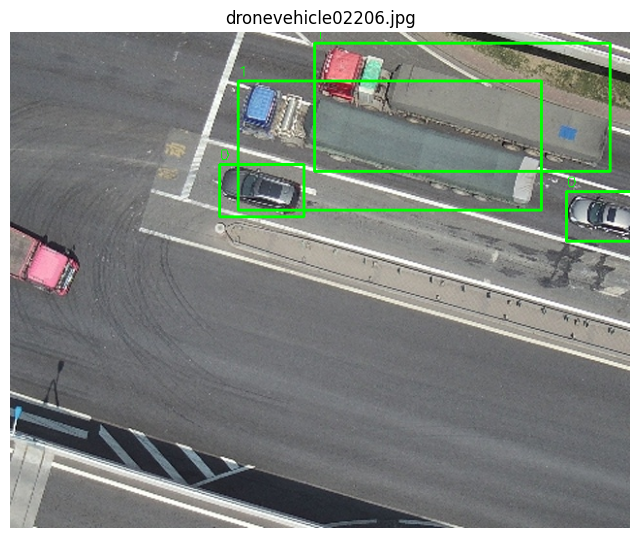

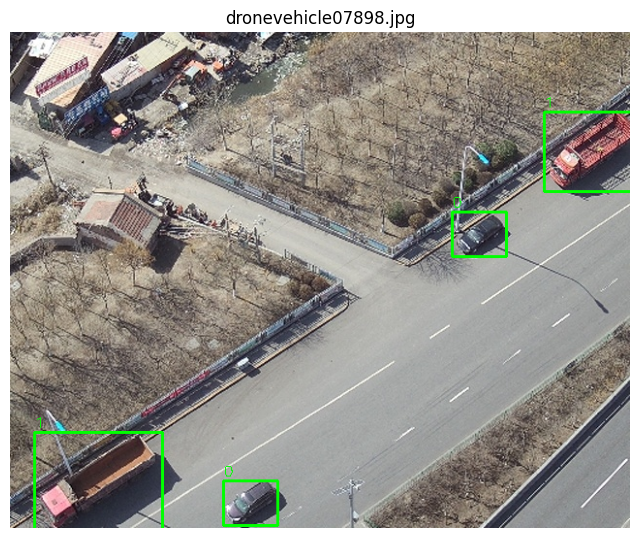

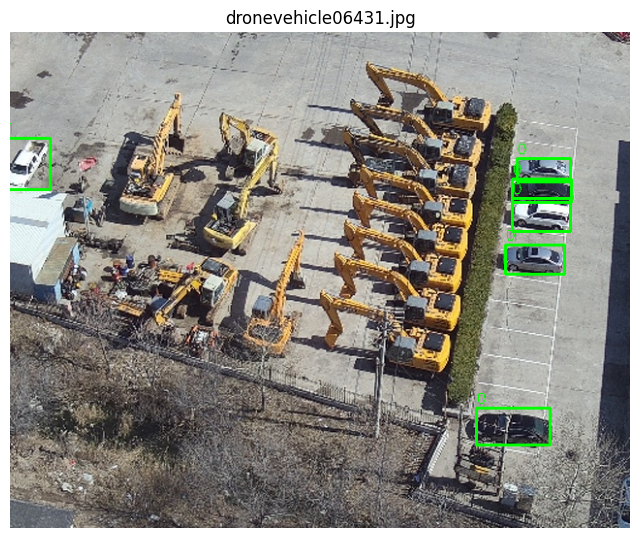

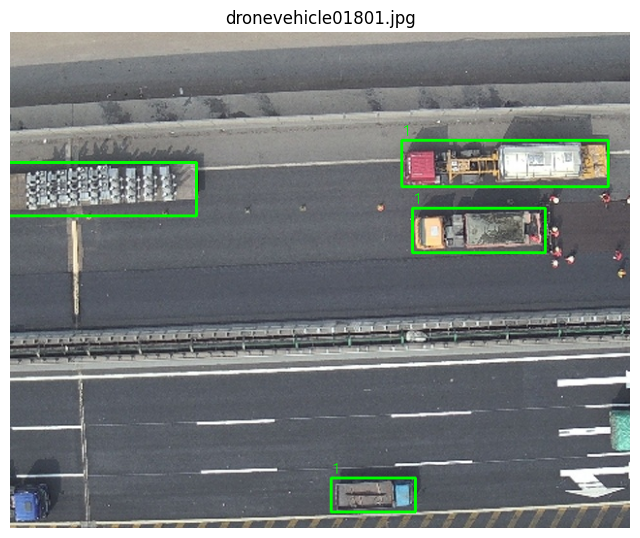

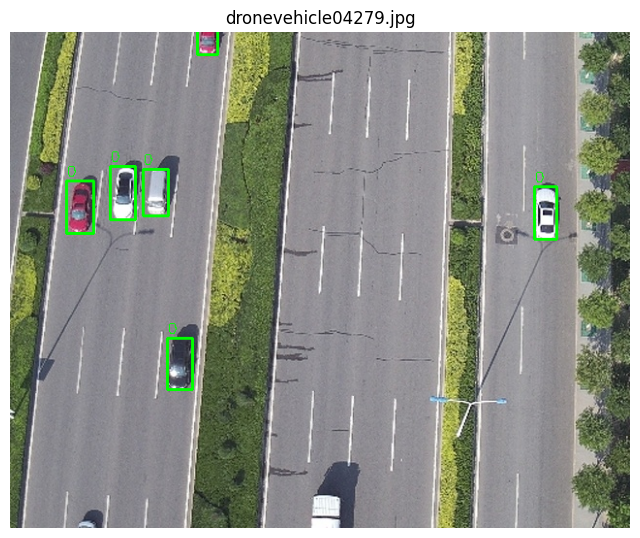

In [ ]:
#check if properly overlaid

import matplotlib.pyplot as plt

# How many images to display
N_IMAGES = 5

# Find some dronevehicle images again
dronevehicle_images = [f for f in image_files if 'dronevehicle' in f]

# Randomly sample a few, or just take the first few
sampled_images = dronevehicle_images[:N_IMAGES]

for img_path in sampled_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads BGR, matplotlib expects RGB
    h, w = img.shape[:2]

    label_path = os.path.splitext(img_path)[0] + '.txt'

    # Draw boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x_center, y_center, box_w, box_h = map(float, parts)

                # Convert from normalized to absolute
                xc = x_center * w
                yc = y_center * h
                bw = box_w * w
                bh = box_h * h

                x1 = int(xc - bw / 2)
                y1 = int(yc - bh / 2)
                x2 = int(xc + bw / 2)
                y2 = int(yc + bh / 2)

                # Draw rectangle
                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
                # Optionally, add class label
                cv2.putText(img_rgb, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
    plt.show()


In [ ]:
import os
import shutil
import re

split_ratio = 0.8  # 80% train, 20% val

source_rgb_dir = 'train_val/rgb/'
source_ir_dir = 'train_val/tir/'

dest_root = 'data/'

In [ ]:
# TODO: move these to external util files
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def get_ir_filename(rgb_filename):
    """
    Given an RGB filename like car146car.jpg, return the matching IR filename: carIR_146car.jpg
    """
    match = re.search(r'(\d+[^/]*)\.jpg$', rgb_filename)
    if match:
        suffix = match.group(1)
        return rgb_filename.replace(suffix + '.jpg', f'IR_{suffix}.jpg')
    else:
        raise ValueError(f"Could not parse IR match from: {rgb_filename}")

def move_grouped_files(group_files, split_ratio):
    """
    Copy RGB, IR (tir), and TXT files into train/val sets.
    """
    split_idx = int(len(group_files) * split_ratio)
    train_set = group_files[:split_idx]
    val_set = group_files[split_idx:]

    for phase, files in [('train', train_set), ('val', val_set)]:
        for file_path in files:
            rel_path = os.path.relpath(file_path, source_rgb_dir)
            subdir = os.path.dirname(rel_path)
            base_name = os.path.basename(file_path)

            # --- Copy RGB image ---
            rgb_dest = os.path.join(dest_root, phase, 'rgb', subdir)
            ensure_dir(rgb_dest)
            shutil.copy2(file_path, os.path.join(rgb_dest, base_name))

            # --- Copy TXT annotation ---
            txt_file = file_path.replace('.jpg', '.txt')
            if os.path.exists(txt_file):
                txt_dest = os.path.join(dest_root, phase, 'rgb', subdir)
                ensure_dir(txt_dest)
                shutil.copy2(txt_file, os.path.join(txt_dest, os.path.basename(txt_file)))

            # --- Copy TIR (IR) image ---
            ir_basename = get_ir_filename(base_name)
            ir_file = os.path.join(source_ir_dir, subdir, ir_basename)
            if os.path.exists(ir_file):
                tir_dest = os.path.join(dest_root, phase, 'tir', subdir)
                ensure_dir(tir_dest)
                shutil.copy2(ir_file, os.path.join(tir_dest, ir_basename))

                ir_txt_file = ir_file.replace('.jpg', '.txt')
                if os.path.exists(ir_txt_file):
                    shutil.copy2(ir_txt_file, os.path.join(tir_dest, os.path.basename(ir_txt_file)))


def extract_source_dataset(filename):
    """
    Extract leading characters up to first digit using regex.
    Slightly faster and more compact than manual scan.
    """
    name = os.path.splitext(filename)[0]  # remove extension
    match = re.match(r'^([^\d]+)', name)  # match from start until first digit
    if match:
        return match.group(1)
    else:
        return 'unknown'

def check_consistency_and_cleanup_source():
    """
    Scan the original train_val/rgb and train_val/tir folders.
    Remove any RGB images that are missing their TXT annotation or matching TIR image.
    """
    removed = 0
    for root, dirs, files in os.walk(source_rgb_dir):
        for file in files:
            if file.lower().endswith('.jpg'):
                rgb_path = os.path.join(root, file)
                txt_path = rgb_path.replace('.jpg', '.txt')

                rel_subdir = os.path.relpath(root, source_rgb_dir)
                ir_basename = get_ir_filename(file)
                ir_path = os.path.join(source_ir_dir, rel_subdir, ir_basename)

                if not os.path.exists(txt_path) or not os.path.exists(ir_path):
                    print(f"Removing incomplete pair: {rgb_path}")
                    os.remove(rgb_path)
                    if os.path.exists(txt_path):
                        os.remove(txt_path)
                    removed += 1
    print(f"\nCleanup complete. Removed {removed} incomplete RGB-IR pairs.")

In [ ]:
# Group all RGB .jpg files by time-of-day (first subdirectory under /rgb/)
# then by source dataset (prefix before first underscore)

check_consistency_and_cleanup_source()

grouped_files = {}

for root, dirs, files in os.walk(source_rgb_dir):
    for file in files:
        if file.lower().endswith('.jpg'):
            rel_path = os.path.relpath(root, source_rgb_dir)
            parts = rel_path.split(os.sep)
            time_of_day = parts[0] if parts else 'default'

            # Correct extraction
            source_dataset = extract_source_dataset(file)

            grouped_files.setdefault(time_of_day, {}).setdefault(source_dataset, []).append(os.path.join(root, file))

# Now sort and split separately within each group
for time_of_day, source_dict in grouped_files.items():
    for source_dataset, file_list in source_dict.items():
        file_list.sort()  # preserve temporal order
        print(f"Processing time of day '{time_of_day}', source dataset '{source_dataset}' with {len(file_list)} files...")
        move_grouped_files(file_list, split_ratio)

In [ ]:
# !export WANDB_API_KEY=<api_key>

In [ ]:
# Configure wandb logging. you will need to set your API key through colab local variables or os variables.

from google.colab import userdata

WANDB_API_KEY = userdata.get('WANDB_API_KEY')
# WANDB_API_KEY = os.environ.get("WANDB_API_KEY")

# Check if key is loaded
if WANDB_API_KEY is None:
    print("WANDB_API_KEY environment variable not set!")
else:
    !wandb login $WANDB_API_KEY

In [ ]:
#If encountering numpy dependency issues, try this.

!pip uninstall tensorflow tensorboard jax jaxlib -y
!pip install numpy==1.23.5 tensorboard==2.11

In [ ]:
# get weights for yolov7-tiny base model, or model of your choosing. Our weights are available here: https://drive.google.com/drive/folders/1Hike1cY2mF2tC7Wl7zxgiahxMxVL3sXB.
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [ ]:
#clear existing runs/fuse images between runs for logging purposes

!rm -rf runs/train/*
!rm -rf fused_samples/*

In [ ]:
#toggle wandb logging visibility

!wandb offline
#!wandb online

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


In [ ]:
%cd thesis
# train mid fusion model
# freezing 20 layers to relearn high level features while maintaining low level features like edges
# may attempt a full training run soon

!python train.py --img 640 --batch 16 --epochs 50 --data early_fusion_data.yaml --cfg early_fusion_manual.yaml --weights /content/thesis/yolov7-tiny.pt --hyp hyp.scratch.custom.yaml --name early_fusion_test

In [ ]:
# If desired, download run

from google.colab import files
import shutil

shutil.make_archive('mid_fusion_learned', 'zip', 'runs/train/mid_fusion_learned')
files.download('mid_fusion_learned.zip')

shutil.make_archive('mid_fusion_learned_imgs', 'zip', 'fused_samples')
files.download('mid_fusion_learned_imgs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from models.experimental import attempt_load

# Load your trained model
model = attempt_load('runs/train/early_fusion_manual_4/weights/best.pt', map_location='cpu')

# Verify the model architecture
print(model)

In [ ]:
# Alternatively, you may use tensorboard logging instead of wandb

%load_ext tensorboard
%tensorboard --logdir runs/train

In [ ]:
# Displays test results on the validation set
!python test.py --img 640 --batch 16 --data mid_fusion_data.yaml --device=0 --weights runs/train/mid_fusion_manual2/weights/best.pt --conf 0.1 --iou 0.65 --name mid_fusion_manual